# Imports

In [143]:
import tensorflow as tf

In [144]:
import pandas as pd

In [145]:
import numpy as np

In [146]:
# import pertinent libraries
import os
import sys
import datetime
import glob as glob
import numpy as np
# [Keras Models]
# import the Keras implementations of VGG16, VGG19, InceptionV3 and Xception models
# the model used here is VGG16
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import SGD
import tensorflow

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [147]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [148]:
import tensorflow_addons as tfa

In [149]:
import cv2

# Data

## Data Augmentation

In [150]:
import Augmentor
p = Augmentor.Pipeline("E:\\Bali\\Kaggle Competition\\train")
p.rotate90(probability=0.7)
#p.zoom(probability=0.5, min_factor=1.1, max_factor=1.3)
p.flip_random(probability = 0.2)
#p.skew(0.5,magnitude=1)
p.random_brightness(0.3,0.75,1.25)
p.process()
p.sample(3000)

Initialised with 600 image(s) found.
Output directory set to E:\Bali\Kaggle Competition\train\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x16E7F2ACD90>: 100%|█| 600/600 [00:01<00:00, 443.96 Samples
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x16EB4A4AF10>: 100%|█| 3000/3000 [00:06<00:00, 434.73 Sampl


## Bilateral Filtering

In [151]:
def Bilateral_filtering(directory):
    for filename in os.listdir(directory):       
        # load the image
        img = cv2.imread(os.path.join(directory, filename))

        # apply bilateral filtering
        filtered_img = cv2.bilateralFilter(img, 6, 75,1475)

        # save the filtered image
        cv2.imwrite(os.path.join(directory,filename), filtered_img)
    

### Train

In [152]:
directory = "E:\\Bali\\Kaggle Competition\\train\\output\\Positive"
Bilateral_filtering(directory)

In [153]:
directory = "E:\\Bali\\Kaggle Competition\\train\\output\\Negative"
Bilateral_filtering(directory)

### Val and Test

In [154]:
directory = "E:\\Bali\\Kaggle Competition\\valid\\Positive"
Bilateral_filtering(directory)
directory = "E:\\Bali\\Kaggle Competition\\valid\\Negative"
Bilateral_filtering(directory)

directory = "E:\\Bali\\Kaggle Competition\\test\\Positive"
Bilateral_filtering(directory)
directory = "E:\\Bali\\Kaggle Competition\\test\\Negative"
Bilateral_filtering(directory)

## Grayscaling

In [156]:
def Grayscaling(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            filepath = os.path.join(directory, filename)
            image = cv2.imread(filepath)
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(filepath, gray_image)

### Train

In [157]:
directory = "E:\\Bali\\Kaggle Competition\\train\\output\\Positive"
Grayscaling(directory)
directory = "E:\\Bali\\Kaggle Competition\\train\\output\\Negative"
Grayscaling(directory)

### Val and Test

In [158]:
directory = "E:\\Bali\\Kaggle Competition\\valid\\Positive"
Grayscaling(directory)
directory = "E:\\Bali\\Kaggle Competition\\valid\\Negative"
Grayscaling(directory)

directory = "E:\\Bali\\Kaggle Competition\\test\\Positive"
Grayscaling(directory)
directory = "E:\\Bali\\Kaggle Competition\\test\\Negative"
Grayscaling(directory)

# Data Generators

In [159]:
negative_images = os.listdir("E:\\Bali\\Kaggle Competition\\train\\output\\Negative")
positive_images = os.listdir("E:\\Bali\\Kaggle Competition\\train\\output\\Positive")

In [160]:
num_classes = 2
image_resize = 224
batch_size_training = 50
batch_size_validation = 50

In [161]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [162]:
train_generator = data_generator.flow_from_directory(
    "E:\\Bali\\Kaggle Competition\\train\\output",
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

Found 3600 images belonging to 2 classes.


In [163]:
validation_generator = data_generator.flow_from_directory(
    'E:\\Bali\\Kaggle Competition\\valid',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_validation,
    class_mode='categorical')

Found 200 images belonging to 2 classes.


# Model

In [164]:
model = Sequential()
model.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))
model.add(Dense(num_classes, activation='softmax'))


In [165]:
model.add(Dense(2, activation = "sigmoid"))

In [166]:
model.layers[0].trainable = False

In [167]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_14 (Dense)            (None, 2)                 4098      
                                                                 
 dense_15 (Dense)            (None, 2)                 6         
                                                                 
Total params: 23,591,816
Trainable params: 4,104
Non-trainable params: 23,587,712
_________________________________________________________________


In [168]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=2, average="micro")])

In [169]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 20

In [170]:
fit_history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,
)

Epoch 1/20


C:\Users\ASUS\AppData\Local\Temp\ipykernel_19804\251737888.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_history = model.fit_generator(


72/72 [==============================] - 32s 405ms/step - loss: 0.4496 - f1_score: 0.8736 - val_loss: 0.3798 - val_f1_score: 0.9800
Epoch 2/20
72/72 [==============================] - 29s 396ms/step - loss: 0.3414 - f1_score: 0.9875 - val_loss: 0.3190 - val_f1_score: 0.9900
Epoch 3/20
72/72 [==============================] - 28s 393ms/step - loss: 0.2899 - f1_score: 0.9911 - val_loss: 0.2732 - val_f1_score: 0.9900
Epoch 4/20
72/72 [==============================] - 28s 390ms/step - loss: 0.2506 - f1_score: 0.9933 - val_loss: 0.2412 - val_f1_score: 0.9900
Epoch 5/20
72/72 [==============================] - 30s 412ms/step - loss: 0.2194 - f1_score: 0.9953 - val_loss: 0.2112 - val_f1_score: 0.9850
Epoch 6/20
72/72 [==============================] - 30s 408ms/step - loss: 0.1934 - f1_score: 0.9967 - val_loss: 0.1843 - val_f1_score: 0.9950
Epoch 7/20
72/72 [==============================] - 30s 410ms/step - loss: 0.1717 - f1_score: 0.9978 - val_loss: 0.1634 - val_f1_score: 0.9950
Epoch 8/20

In [171]:
model.evaluate_generator(test_generator,steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19804\1865615202.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator,steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)


[0.05357326939702034, 1.0]

In [172]:
model.save('resnet_model1.h5')

# Model 2

In [173]:
from keras.applications.vgg16 import VGG16


In [174]:
model_vgg = Sequential()
model_vgg.add(VGG16(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))
model_vgg.add(Dense(num_classes, activation='softmax'))
model_vgg.add(Dense(num_classes, activation ='sigmoid'))

In [175]:
model_vgg.layers[0].trainable = False

In [176]:
model_vgg.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_16 (Dense)            (None, 2)                 1026      
                                                                 
 dense_17 (Dense)            (None, 2)                 6         
                                                                 
Total params: 14,715,720
Trainable params: 1,032
Non-trainable params: 14,714,688
_________________________________________________________________


In [177]:
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=2, average="micro")])

In [178]:
fit_history_vgg = model_vgg.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,
    
)

Epoch 1/20


C:\Users\ASUS\AppData\Local\Temp\ipykernel_19804\2788884500.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_history_vgg = model_vgg.fit_generator(


72/72 [==============================] - 52s 710ms/step - loss: 0.5394 - f1_score: 0.8117 - val_loss: 0.3931 - val_f1_score: 0.9650
Epoch 2/20
72/72 [==============================] - 51s 707ms/step - loss: 0.3707 - f1_score: 0.9439 - val_loss: 0.3265 - val_f1_score: 0.9700
Epoch 3/20
72/72 [==============================] - 51s 709ms/step - loss: 0.3169 - f1_score: 0.9611 - val_loss: 0.2895 - val_f1_score: 0.9650
Epoch 4/20
72/72 [==============================] - 51s 706ms/step - loss: 0.2783 - f1_score: 0.9717 - val_loss: 0.2592 - val_f1_score: 0.9650
Epoch 5/20
72/72 [==============================] - 51s 707ms/step - loss: 0.2490 - f1_score: 0.9747 - val_loss: 0.2342 - val_f1_score: 0.9750
Epoch 6/20
72/72 [==============================] - 51s 707ms/step - loss: 0.2238 - f1_score: 0.9803 - val_loss: 0.2102 - val_f1_score: 0.9800
Epoch 7/20
72/72 [==============================] - 51s 707ms/step - loss: 0.2022 - f1_score: 0.9817 - val_loss: 0.1910 - val_f1_score: 0.9850
Epoch 8/20

In [181]:
model_vgg.save('vgg16_model1.h5')

In [179]:
data_generator_test = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)
test_generator = data_generator_test.flow_from_directory(
    'E:\\Bali\\Kaggle Competition\\test',
    target_size=(image_resize, image_resize),
    shuffle=False)


Found 200 images belonging to 2 classes.


In [180]:
model_vgg.evaluate_generator(test_generator,steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19804\1474210604.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model_vgg.evaluate_generator(test_generator,steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)


[0.06273682415485382, 1.0]

## Final Metrics

In [182]:
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    f1_val = 2*((precision_val*recall_val)/(precision_val+recall_val+K.epsilon()))
    return f1_val




In [185]:
#compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',recall,precision,f1_score])


### An array of [Loss, Accuracy, Recall, Precision, F1 Score]

In [186]:
model.evaluate_generator(test_generator,steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19804\1865615202.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator,steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)


[0.05357326939702034, 1.0, 1.0, 1.0, 1.0]

### Prediction for cases

In [205]:
directory = "E:\\Bali\\Kaggle Competition\\predict\\Positive"
Bilateral_filtering(directory)
Grayscaling(directory)


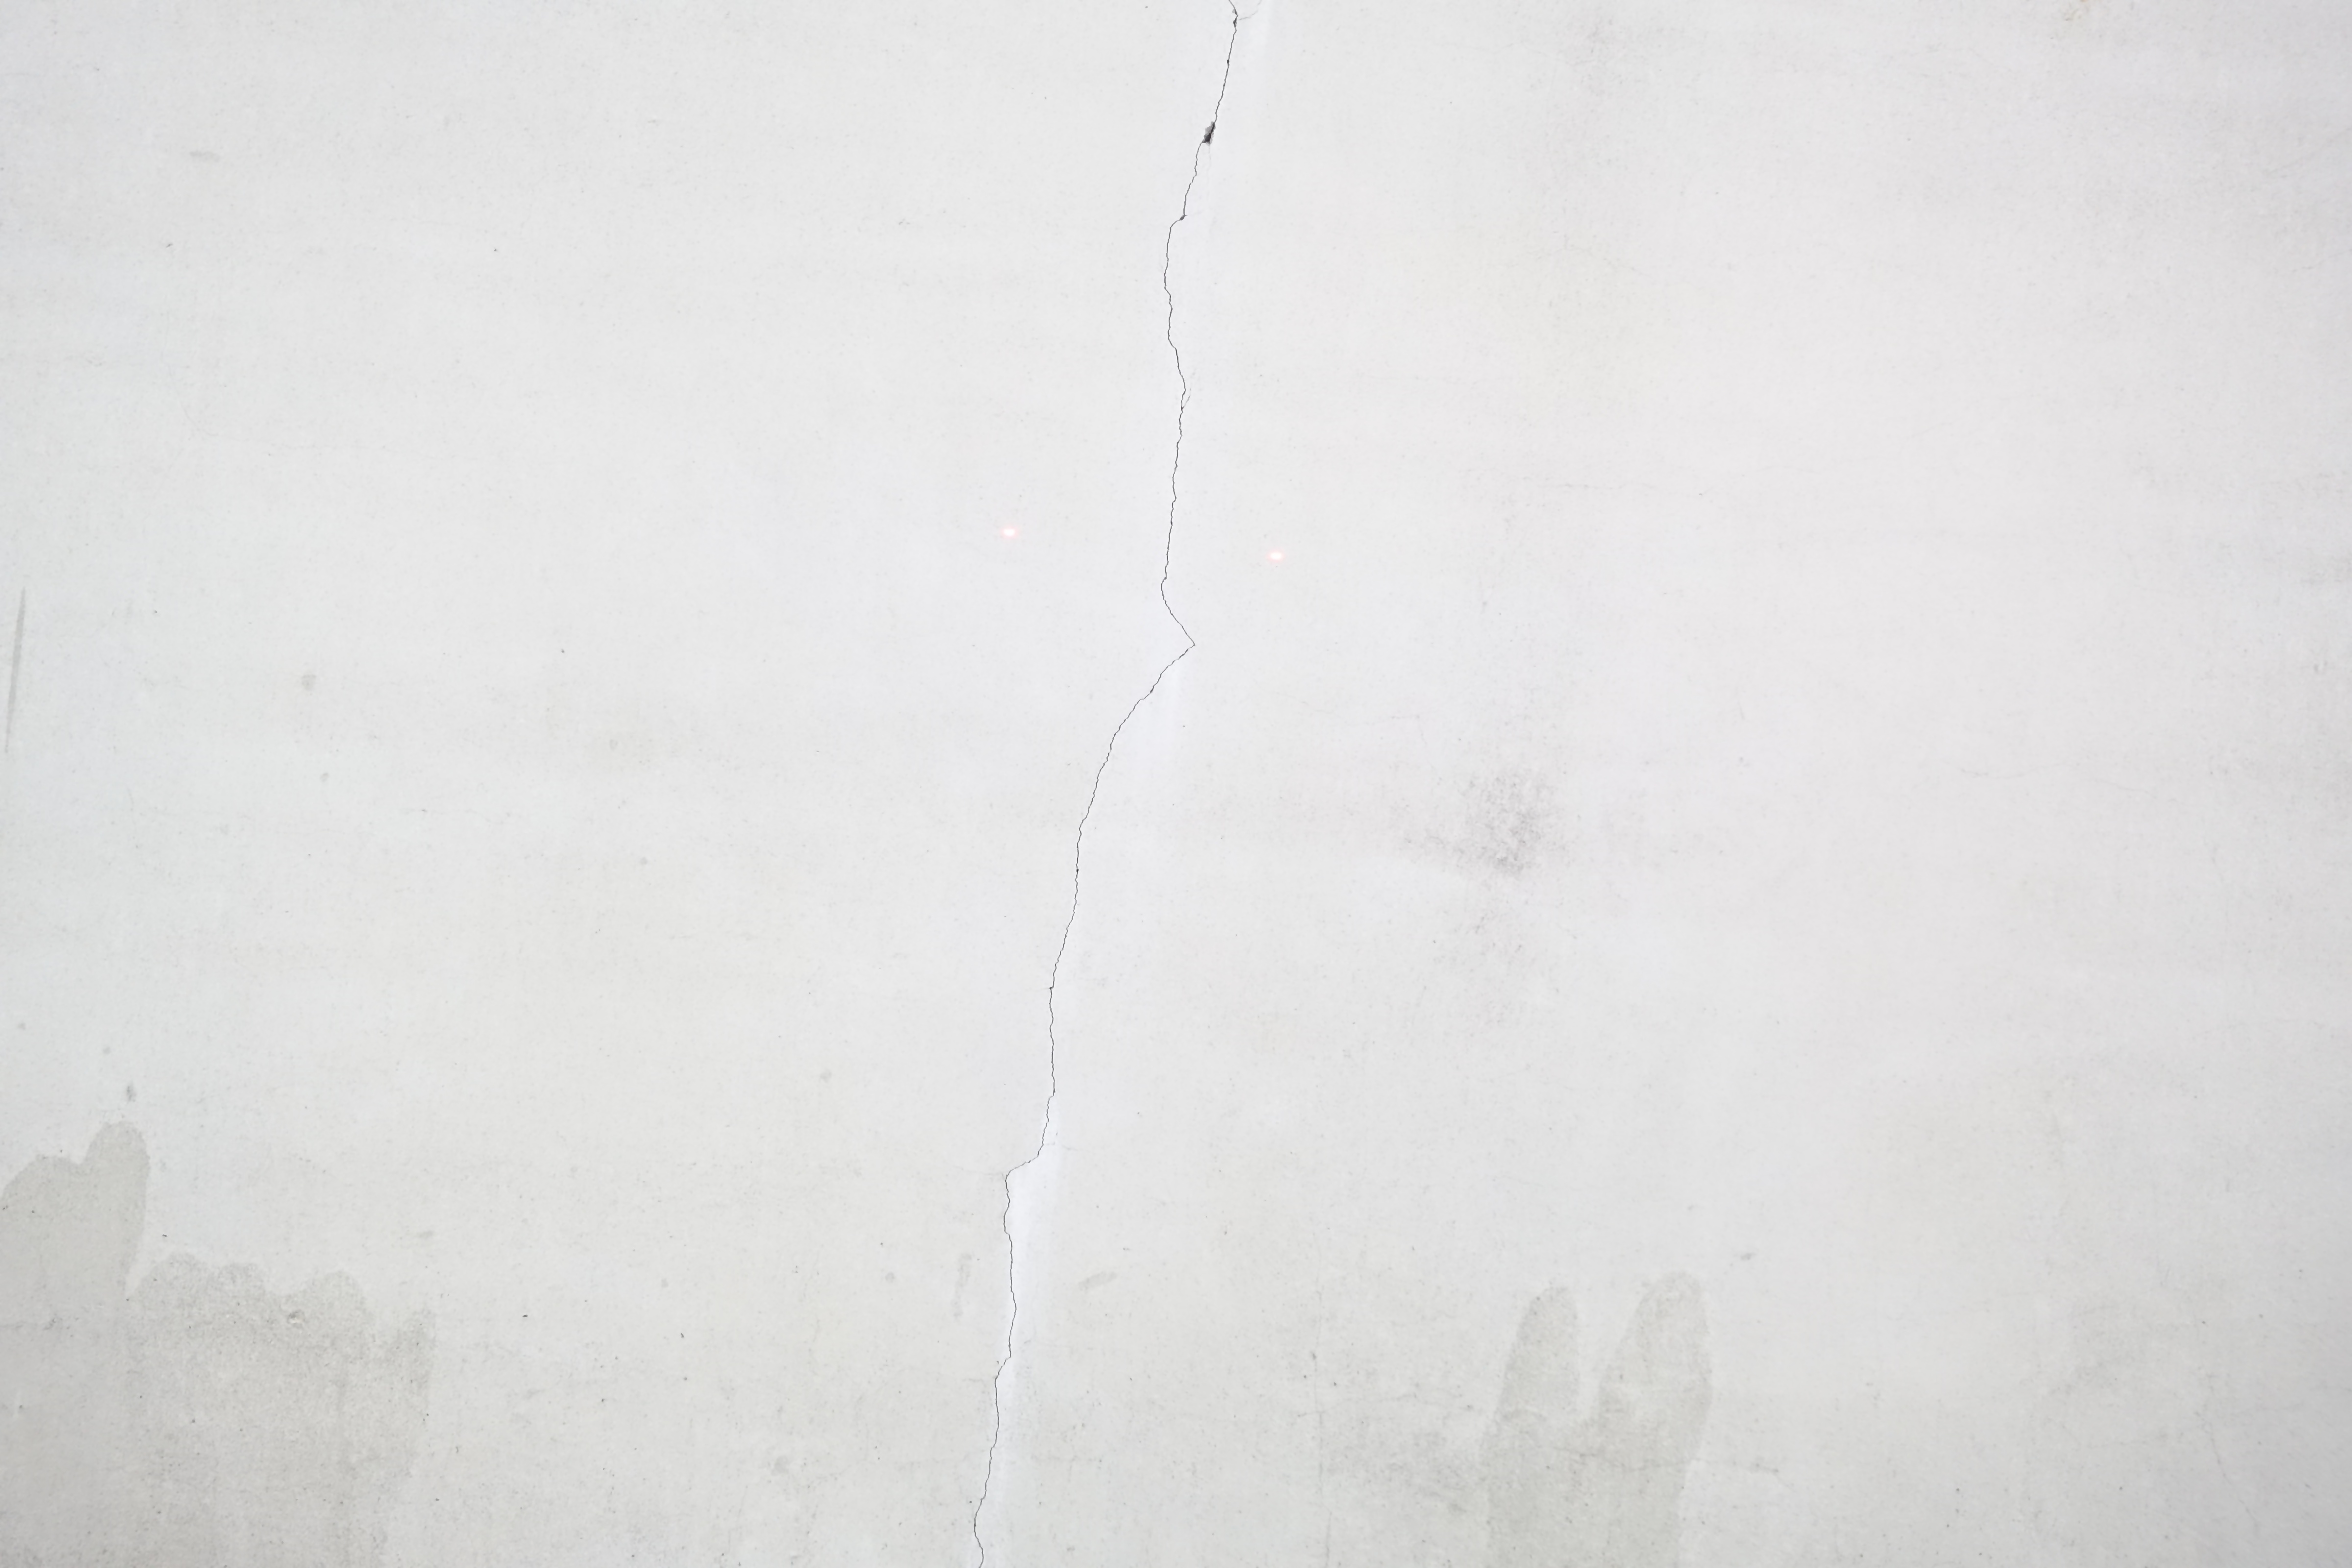

In [212]:
from IPython.display import Image
Image(filename='E:\\Bali\\Kaggle Competition\\predict\\IMG_1129.JPG') 

In [210]:
img = image.load_img("E:\\Bali\\Kaggle Competition\\predict\\IMG_1129.JPG", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

In [211]:
model = keras.models.load_model('resnet_model1.h5')

# Make a prediction
predictions = model.predict(x)

# Decode the predictions
# Load the class labels
class_labels = [ "Negative","Positive"]

# Get the index of the class with the highest probability
top_class_index = np.argmax(predictions)

# Get the class label
top_class_label = class_labels[top_class_index]
print(top_class_label)







Positive
